In [ ]:
# Установка основных библиотек
!pip install torchvision torch numpy pandas matplotlib scikit-learn tqdm


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time

1. загрузка и предобработка данных

In [12]:
# Этап 1. загрузка и предобработка данных

# Параметры
DATA_DIR = 'dataset'  # путь к датасету
BATCH_SIZE = 32
IMG_SIZE = 224  # стандартный размер для многих предобученных моделей

# 1. Определяем преобразования для обучающего и валидационного наборов
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation([-10,10]),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # стандартные значения для ImageNet
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Загружаем датасет
full_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, 'train'),
    transform=train_transform
)

#  Тестовый датасетт
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#  Разделение на train и validation (например, 80% / 20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

#  Создаём DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Выводим статистику
# Берём классы из исходного full_dataset (у него есть .classes)
num_classes = len(full_dataset.classes)
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)

print(f'Количество классов: {num_classes}')
print(f'Количество изображений в обучающем наборе: {num_train_images}')
print(f'Количество изображений в валидационном наборе: {num_val_images}')
print(f"Количество изображений в тестовой выборке: {len(test_dataset)}")
print(f'Примеры классов: {full_dataset.classes[:5]}...')

Количество классов: 84
Количество изображений в обучающем наборе: 1881
Количество изображений в валидационном наборе: 471
Количество изображений в тестовой выборке: 504
Примеры классов: ['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg']...


2.Объявление модели

In [43]:
# Этап 2.Объявление модели

# Параметры
NUM_CLASSES = 84
FREEZE_BACKBONE = True
num_ftrs=512

# Загружаем предобученные веса
weights = weights = models.ResNet101_Weights.IMAGENET1K_V1
# Загружаем предобученную модель (например, ResNet101)
model = models.resnet101(pretrained=True)



#  Замораживаем веса backbone
if FREEZE_BACKBONE:
    for param in model.parameters():
        param.requires_grad = False

# Заменяем последний полносвязный слой (classifier) на новый
# В ResNet последний слой называется `fc`
num_ftrs = model.fc.in_features  # число входных признаков для последнего слоя


model.fc = nn.Linear(num_ftrs, NUM_CLASSES)  # новый классификатор


#  Проверяем, какие параметры обучаются
print('Обучаемые параметры:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
print(f"Модель использует {sum(p.numel() for p in model.parameters() if p.requires_grad):,} обучаемых параметров")

#  Перемещаем модель на GPU (если доступно)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f'Модель готова к обучению. Устройство: {device}')

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:01<00:00, 178MB/s]


Обучаемые параметры:
fc.weight
fc.bias
Модель использует 172,116 обучаемых параметров
Модель готова к обучению. Устройство: cuda


3. Обучение сети

In [45]:

# Этап 3.Jбучение сети
# Параметры обучения
NUM_EPOCHS = 10           # количество эпох
BATCH_SIZE = 32
LEARNING_RATE = 0.001    # базовая скорость обучения
MOMENTUM = 0.9           # параметр для SGD
STEP_SIZE = 5             # период уменьшения LR
GAMMA = 0.5              # коэффициент уменьшения LR
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Перемещаем модель на устройство
model = model.to(DEVICE)

# Функция потерь
criterion = nn.CrossEntropyLoss()

# Оптимизатор: если заморожены веса, обучаем только classifier
if FREEZE_BACKBONE:
    optimizer = optim.SGD(model.fc.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
else:
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)


# Планировщик изменения скорости обучения
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Списки для сохранения метрик
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f'Начало обучения. Устройство: {DEVICE}')
print(f'Эпохи: {NUM_EPOCHS}, Батч-размер: {BATCH_SIZE}, LR: {LEARNING_RATE}\n')

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    print(f'Эпоха {epoch + 1}/{NUM_EPOCHS}')
    print('-' * 20)

    # Режимы: обучение и валидация
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        # Проход по батчам
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Накопление статистики
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        # Сохранение метрик
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            scheduler.step()  # обновление LR после валидации

        # Вывод результатов эпохи
        print(f'{phase:5s} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    epoch_time = time.time() - epoch_start_time
    print(f'Время эпохи: {epoch_time//60:.0f}м {epoch_time%60:.0f}с\n')

        # Сохранение чекпоинта после каждой эпохи
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'train_acc': train_accuracies[-1],
        'val_acc': val_accuracies[-1]
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pt')

# Перемещение модели обратно на CPU перед сохранением (рекомендуется для совместимости)
model.to('cpu')

# Сохранение обученной модели
torch.save(model.state_dict(), 'meds_classifier.pt')
print('Модель сохранена в файл \'meds_classifier.pt\'')


Начало обучения. Устройство: cuda
Эпохи: 10, Батч-размер: 32, LR: 0.001

Эпоха 1/10
--------------------
train Loss: 4.3567 Acc: 0.0372
val   Loss: 4.3256 Acc: 0.0531
Время эпохи: 2м 55с

Эпоха 2/10
--------------------
train Loss: 4.2443 Acc: 0.0819
val   Loss: 4.2279 Acc: 0.1104
Время эпохи: 2м 53с

Эпоха 3/10
--------------------
train Loss: 4.1571 Acc: 0.1207
val   Loss: 4.1070 Acc: 0.1635
Время эпохи: 3м 11с

Эпоха 4/10
--------------------
train Loss: 4.0527 Acc: 0.1611
val   Loss: 4.1429 Acc: 0.1380
Время эпохи: 3м 19с

Эпоха 5/10
--------------------
train Loss: 3.9679 Acc: 0.2015
val   Loss: 3.9399 Acc: 0.1953
Время эпохи: 3м 9с

Эпоха 6/10
--------------------
train Loss: 3.8732 Acc: 0.2270
val   Loss: 3.8757 Acc: 0.2293
Время эпохи: 2м 59с

Эпоха 7/10
--------------------
train Loss: 3.8330 Acc: 0.2648
val   Loss: 3.8386 Acc: 0.2399
Время эпохи: 2м 56с

Эпоха 8/10
--------------------
train Loss: 3.7835 Acc: 0.2967
val   Loss: 3.8138 Acc: 0.2314
Время эпохи: 2м 52с

Эпоха 9/

Промежуточный анализ результатов: модель не достигла требуемого уровня качества 75% после 10 эпох (всего 27.6% ).На валидационном датасете качество начало падать после 9 эпохи. Пробуем использовать отлично зарекомендовавшую себя модель ConvNeXt.

Возвращение на этап 2. Объявляем модель ConvNeXt

In [48]:
# Этап 2. Объявление модели ConvNeXt

# Параметры
NUM_CLASSES = 84
FREEZE_BACKBONE = True

# Загружаем предобученные веса для ConvNeXt
weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = models.convnext_tiny(weights=weights)

# Замораживаем веса backbone
if FREEZE_BACKBONE:
    for param in model.parameters():
        param.requires_grad = False

# Динамически определяем входной размер классификатора
if isinstance(model.classifier, nn.Sequential):
    # Если classifier — последовательность, ищем последний Linear/Conv2d слой
    last_layer = None
    for layer in model.classifier:
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            last_layer = layer

    if last_layer is None:
        raise ValueError("Не найден линейный/сверточный слой в classifier")

    if isinstance(last_layer, nn.Linear):
        num_ftrs = last_layer.in_features
    else:  # nn.Conv2d
        num_ftrs = last_layer.out_channels
else:
    # Если classifier — одиночный слой
    if isinstance(model.classifier, nn.Linear):
        num_ftrs = model.classifier.in_features
    elif isinstance(model.classifier, nn.Conv2d):
        num_ftrs = model.classifier.out_channels
    else:
        raise TypeError(f"Неподдерживаемый тип classifier: {type(model.classifier)}")

# Заменяем последний слой
if isinstance(model.classifier, nn.Sequential):
    # Создаем новый Sequential, заменяя последний слой
    new_classifier = nn.Sequential(*list(model.classifier)[:-1])
    new_classifier.add_module(
        str(len(new_classifier)),
        nn.Linear(num_ftrs, NUM_CLASSES)
    )
    model.classifier = new_classifier
else:
    model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

# Проверяем обучаемые параметры
print('Обучаемые параметры:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
print(f"Модель использует {sum(p.numel() for p in model.parameters() if p.requires_grad):,} обучаемых параметров")

# Перемещаем на GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f'Модель готова к обучению. Устройство: {device}')

Обучаемые параметры:
classifier.2.weight
classifier.2.bias
Модель использует 64,596 обучаемых параметров
Модель готова к обучению. Устройство: cuda


Этап 3. Обучение модели ConvNeXt

In [52]:
# Этап 3. Обучение модели ConvNeXt

# Параметры обучения
NUM_EPOCHS = 10           # количество эпох
BATCH_SIZE = 32
LEARNING_RATE = 0.001     # базовая скорость обучения
STEP_SIZE = 5           # период уменьшения LR
GAMMA = 0.5             # коэффициент уменьшения LR
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Перемещаем модель на устройство
model = model.to(DEVICE)

# Функция потерь
criterion = nn.CrossEntropyLoss()

# Оптимизатор: если заморожены веса, обучаем только classifier
if FREEZE_BACKBONE:
    optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
else:
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Планировщик изменения скорости обучения
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Списки для сохранения метрик
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f'Начало обучения. Устройство: {DEVICE}')
print(f'Эпохи: {NUM_EPOCHS}, Батч-размер: {BATCH_SIZE}, LR: {LEARNING_RATE}\n')

should_stop = False  # Флаг для досрочной остановки обучения

for epoch in range(NUM_EPOCHS):
    if should_stop:
        break  # Прерываем цикл эпох, если достигнута точность > 75%

    epoch_start_time = time.time()

    print(f'Эпоха {epoch + 1}/{NUM_EPOCHS}')
    print('-' * 20)

    # Режимы: обучение и валидация
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        # Проход по батчам
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Накопление статистики
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        # Сохранение метрик
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            scheduler.step()  # обновление LR после валидации

        # Вывод результатов эпохи
        print(f'{phase:5s} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Проверка условия досрочного останова (только на валидации)
        if phase == 'val' and epoch_acc > 0.75:
            print(f"Достигнута точность валидации {epoch_acc:.4f} > 0.75. Остановка обучения.")
            should_stop = True
            break  # Выходим из внутреннего цикла (phase)

    epoch_time = time.time() - epoch_start_time
    print(f'Время эпохи: {epoch_time//60:.0f}м {epoch_time%60:.0f}с\n')

    # Сохранение чекпоинта после каждой эпохи (если не остановили обучение)
    if not should_stop:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_acc': train_accuracies[-1],
            'val_acc': val_accuracies[-1]
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pt')

# Если обучение остановлено досрочно, сохраняем последний чекпоинт
if should_stop:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'train_acc': train_accuracies[-1],
        'val_acc': val_accuracies[-1]
    }
    torch.save(checkpoint, f'checkpoint_early_stop_epoch_{epoch+1}.pt')
    print(f'Обучение остановлено досрочно после эпохи {epoch + 1}. Чекпоинт сохранён.')

# Перемещение модели обратно на CPU перед сохранением (рекомендуется для совместимости)
model.to('cpu')

# Сохранение обученной модели
torch.save(model.state_dict(), 'meds_classifier.pt')
print('Модель сохранена в файл \'meds_classifier.pt\'')

Начало обучения. Устройство: cuda
Эпохи: 10, Батч-размер: 32, LR: 0.001

Эпоха 1/10
--------------------
train Loss: 1.1269 Acc: 0.7448
val   Loss: 1.0118 Acc: 0.7686
Достигнута точность валидации 0.7686 > 0.75. Остановка обучения.
Время эпохи: 2м 58с

Обучение остановлено досрочно после эпохи 2. Чекпоинт сохранён.
Модель сохранена в файл 'meds_classifier.pt'


4. Оценка качества

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


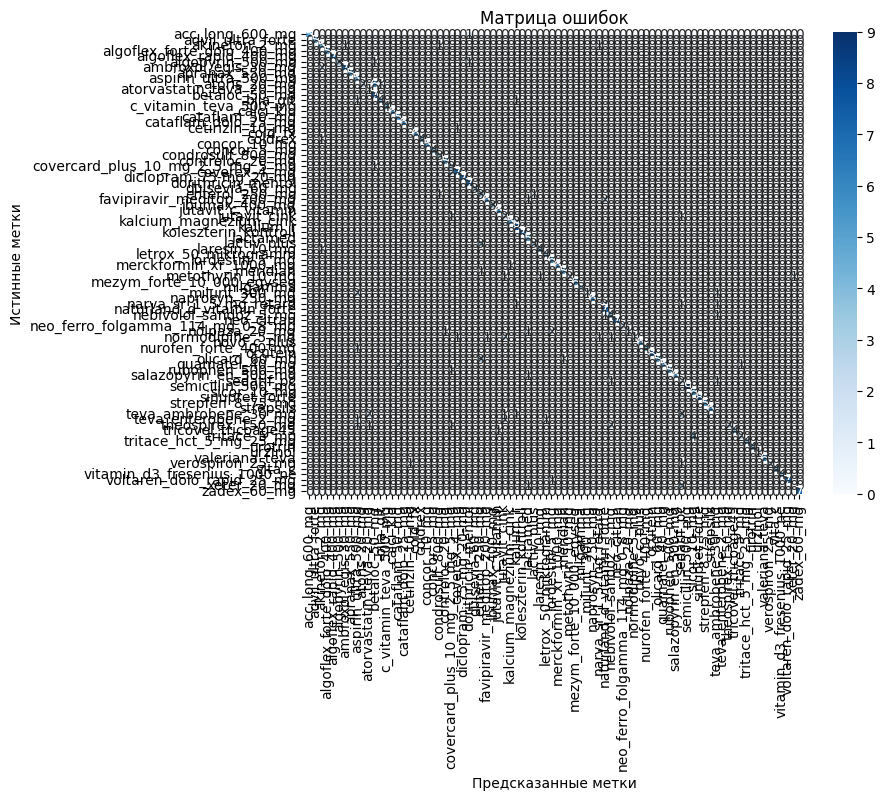

МЕТРИКИ КЛАССИФИКАТОРА НА ВАЛИДАЦИОННОМ НАБОРЕ

METRICS ПО КАЖДОМУ КЛАССУ (Precision, Recall, F1):
------------------------------------------------------------
                           Class  Precision   Recall  F1-Score  Support  Accuracy (per class)
                 acc_long_600_mg   1.000000 0.833333  0.909091      6.0              0.833333
               advil_ultra_forte   1.000000 1.000000  1.000000      5.0              1.000000
                   akineton_2_mg   0.555556 0.625000  0.588235      8.0              0.625000
      algoflex_forte_dolo_400_mg   1.000000 1.000000  1.000000      5.0              1.000000
           algoflex_rapid_400_mg   1.000000 1.000000  1.000000      7.0              1.000000
                algopyrin_500_mg   1.000000 0.600000  0.750000      5.0              0.600000
             ambroxol_egis_30_mg   0.875000 0.777778  0.823529      9.0              0.777778
                  apranax_550_mg   1.000000 1.000000  1.000000      5.0              1.0

In [57]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, val_loader, class_names, device=None):
    """
    Оценка качества модели на валидационном наборе.

    Параметры:
    - model: обученная модель PyTorch
    - val_loader: DataLoader для валидационных данных
    - class_names: список названий классов (например, ['cat', 'dog'])
    - device: устройство ('cuda' или 'cpu'). Если None — определяется автоматически.

    Возвращает: словарь с метриками.
    """

    # Определение устройства
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Сбор истинных меток и предсказаний
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    # Используем переданный список классов
    class_names = list(class_names)  # гарантируем, что это список

    # 1. Отчёт по классам
    report = classification_report(
        y_true, y_pred,
        target_names=class_names,
        output_dict=True
    )

    # 2. Точность по каждому классу
    class_accuracies = {}
    for cls_idx, cls_name in enumerate(class_names):
        mask = (y_true == cls_idx)
        if np.sum(mask) > 0:
            acc = accuracy_score(y_true[mask], y_pred[mask])
            class_accuracies[cls_name] = acc
        else:
            class_accuracies[cls_name] = 0.0

    # 3. Таблица метрик
    df_metrics = pd.DataFrame({
        'Class': class_names,
        'Precision': [report[cls]['precision'] for cls in class_names],
        'Recall': [report[cls]['recall'] for cls in class_names],
        'F1-Score': [report[cls]['f1-score'] for cls in class_names],
        'Support': [report[cls]['support'] for cls in class_names],
        'Accuracy (per class)': [class_accuracies[cls] for cls in class_names]
    })

    # 4. Макро‑средние
    macro_precision = np.mean([report[cls]['precision'] for cls in class_names])
    macro_recall = np.mean([report[cls]['recall'] for cls in class_names])
    macro_f1 = np.mean([report[cls]['f1-score'] for cls in class_names])
    accuracy = report['accuracy']

    # 5. Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)

    # 6. Визуализация
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Матрица ошибок')
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.show()

    # 7. Вывод в консоль
    print('=' * 60)
    print('МЕТРИКИ КЛАССИФИКАТОРА НА ВАЛИДАЦИОННОМ НАБОРЕ')
    print('=' * 60)
    print('\nMETRICS ПО КАЖДОМУ КЛАССУ (Precision, Recall, F1):')
    print('-' * 60)
    print(df_metrics.to_string(index=False))
    print('-' * 60)
    print('ИТОГОВЫЕ МАКРО‑СРЕДНИЕ МЕТРИКИ:')
    print(f'Accuracy (macro):        {accuracy:.4f}')
    print(f'Precision (macro):       {macro_precision:.4f}')
    print(f'Recall (macro):          {macro_recall:.4f}')
    print(f'F1-Score (macro):        {macro_f1:.4f}')

    # Возврат результатов
    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'class_names': class_names,
        'classification_report': report,
        'class_accuracies': class_accuracies,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }
class_names = full_dataset.classes
results = evaluate_model(
    model=model,
    val_loader=val_loader,
    class_names=class_names
)

Выводы:
1. На каких 5 классах модель ошибается чаще всего?
Пять классов с наименьшей точностью (Precision) — именно они демонстрируют самые частые ошибки классификации (модель часто ошибочно относит объекты к этим классам):

sedatif_pc — 0,181818;

xeter_20_mg — 0,000000;

cetrizin_10_mg — 0,000000;

teva_ambrobene_30_mg — 0,000000;

teva_enterobene_2_mg — 0,000000.

Альтернативный взгляд: если ориентироваться на F1‑Score (гармоническое среднее Precision и Recall), пятёрка самых проблемных классов:

sedatif_pc — 0,266667;

normodipine_5_mg — 0,250000;

nolpaza_20_mg — 0,333333;

tritace_5_mg — 0,444444;

covercard_plus_10_mg_2_5_mg_5_mg — 0,500000.

2. Почему модель может ошибаться на этих классах?
Основные причины:

Малый объём выборки (Support = 1–4 экземпляра). Для классов cetrizin_10_mg, xeter_20_mg, teva_ambrobene_30_mg, teva_enterobene_2_mg доступно всего 1–7 примеров. Модель не успевает «увидеть» вариативность признаков.

Сильный дисбаланс классов. Редкие классы хуже представлены в обучающей выборке, поэтому модель склоняется к более частым классам.

Схожесть признаков с другими классами. Например, sedatif_pc может иметь визуальные/текстовые признаки, близкие к другим таблеткам, что ведёт к ложным срабатываниям.

Шум или неточность разметки в обучающих данных для этих классов.

Недостаточная выразительность признаков (например, если названия или изображения слишком похожи).

3. На каких классах модель не совершает ошибок?
Классы с Accuracy = 1.000000 и F1‑Score = 1.000000 (идеальная точность и полнота):

advil_ultra_forte;

algoflex_forte_dolo_400_mg;

algoflex_rapid_400_mg;

apranax_550_mg;

c_vitamin_teva_500_mg;

calci_kid;

cataflam_dolo_25_mg;

cold_fx;

concor_10_mg;

concor_5_mg;

controloc_20_mg;

diclopram_75-mg_20-mg;

dulsevia_60_mg;

ibumax_400_mg;

jutavit_c_vitamin;

koleszterin_kontroll;

mezym_forte_10_000_egyseg;

milgamma;

naprosyn_250_mg;

neo_citran;

neo_ferro_folgamma_114_mg_0_8_mg;

novo_c_plus;

ocutein;

semicillin_500_mg;

sinupret_forte;

strepfen_8_75_mg;

strepsils;

tritace_hct_5_mg_25_mg;

urotrin;

urzinol;

valeriana_teva;

vita_c;

vitamin_d3_fresenius_1000_ne;

zadex_60_mg.

4. Почему эти классы модель распознаёт безошибочно?
Достаточный объём данных (Support ≥ 4). Например, semicillin_500_mg — 9 примеров, sinupret_forte — 8 примеров.

Яркие, уникальные признаки. Атрибуты этих препаратов сильно отличаются от остальных, что упрощает классификацию.

Качественная разметка данных. В обучающей выборке для этих классов, вероятно, минимум ошибок и шума.

Отсутствие близких «конкурирующих» классов. Модель не путается между похожими категориями.

Баланс классов в выборке для этих категорий.

5. Как можно улучшить точность классификатора?
Увеличить объём данных для слабо представленных классов (cetrizin_10_mg, xeter_20_mg и др.).

Перебалансировка выборки (oversampling редких классов, undersampling частых).

Анализ ошибок (confusion matrix) для выявления систематических путаниц.

Удаление шумовых примеров из обучающей выборки.

Дообучение на ошибках (добавить в тренировку примеры, где модель ошибается).

6. Как ещё можно проанализировать результаты и ошибки модели?
Confusion Matrix — покажет, какие классы модель путает между собой (например, sedatif_pc vs tritace_5_mg).

ROC‑AUC и Precision‑Recall кривые — для оценки качества по классам.